In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('..')

In [3]:
from Approximators import LinProgApproximator
from Approximators.Bernstein import CauchySimplex as Bernstein

In [4]:
import Approximators
Approximators.ignore_warnings()

# Fake Data

In [8]:
np.random.seed(0)

function_list = [lambda x: np.arctan(50 * (x - 0.5)),
                 lambda x: abs(2 * (x - 0.5)),
                 lambda x: np.exp(-x) * np.sin(16 * x ** 2)]

x_list = []
y_list = []

for f in function_list:
    x = np.random.rand(1000)
    y = f(x) + np.random.normal(0, 0.01 + x / 10, len(x))
    
    x_list.append(x)
    y_list.append(y)
    
wage_data = pd.read_csv("quasiconvex_test/Wage.csv", index_col=0)

x = wage_data['age'].values
y = wage_data['wage'].values

x = (x - x.min()) / (x.max() - x.min())

x_list.append(x)
y_list.append(y)

In [9]:
n = 10

fitted_models = []

for x, y in zip(x_list, y_list):
    approximators = {f'Bernstein': Bernstein(n, n, max_iter=100, gamma=0.9).fit(x, y),
                     f'Quasiconvex': LinProgApproximator(n, n).fit(x, y),
                     f'Polynomial': Bernstein(2 * n, 0, max_iter=100, gamma=0.9).fit(x, y)}
    fitted_models.append(approximators)

In [21]:
csv_files = ['quasiconvex_test/csv_files/arctan_mse_error.csv',
             'quasiconvex_test/csv_files/abs_mse_error.csv',
             'quasiconvex_test/csv_files/exp_mse_error.csv',
             'quasiconvex_test/csv_files/wage_mse_error.csv']

poles_csv_files = ['quasiconvex_test/csv_files/arctan_poles.csv',
                   'quasiconvex_test/csv_files/abs_poles.csv',
                   'quasiconvex_test/csv_files/exp_poles.csv',
                   'quasiconvex_test/csv_files/wage_poles.csv']

noise_str = r"$\mathcal{N}(0, (0.01 + x/10)^2)$"
text_data = [r"(A) $\arctan(50(x - 0.5))$" + f"\n                 +{noise_str}",
             r"(B) $|10(x - 0.5)|$" + f"\n                 +{noise_str}",
             r"(C) $\exp(-x)\, \sin(16x^2)$" + f"\n                 +{noise_str}",
             "(D) Wage Data"]

text_locations = [(5, 2.5e-2), (14, 4e-2), (14, 4e-2), (14, 50)]

In [22]:
columns_order = ['Bernstein', 'Quasiconvex', 'Polynomial']

In [23]:
markers = ['o', 'v', 's', 'X', 'd', '*', 'p', '>']
colors = ['C3', 'C0', 'C2']

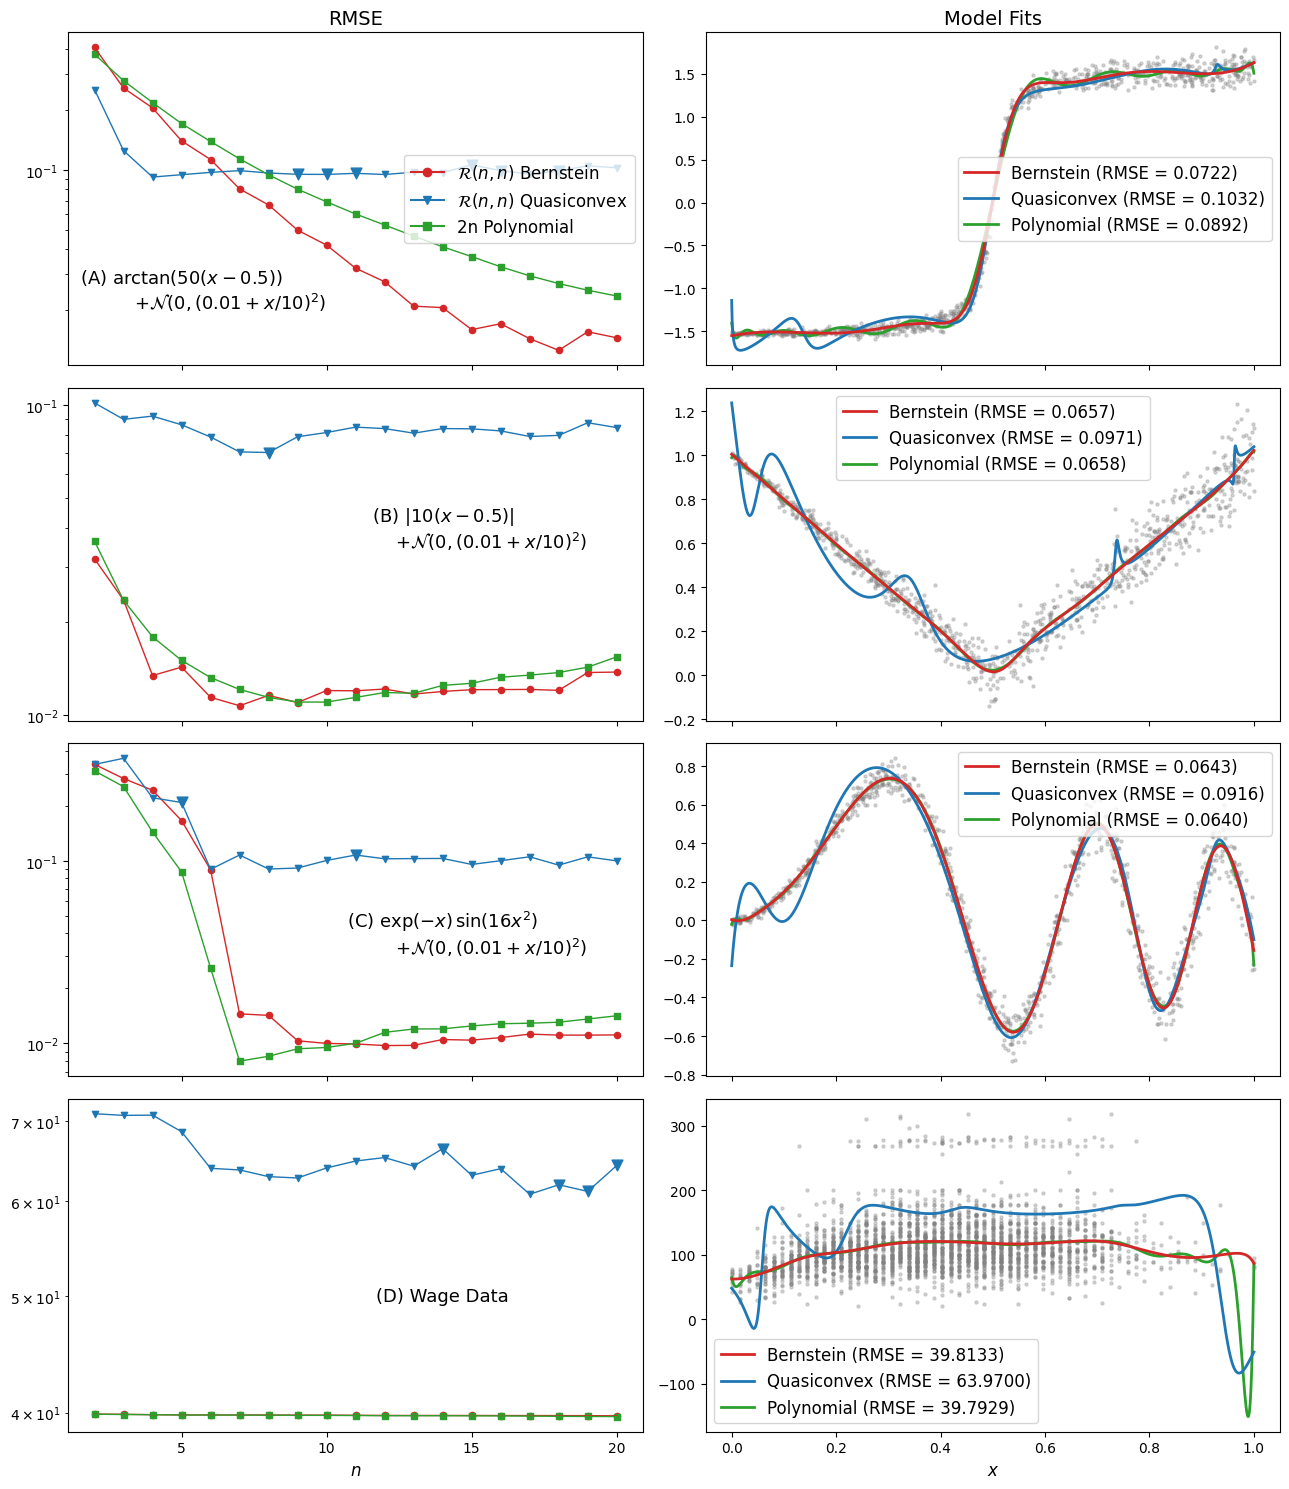

In [24]:
# fig, axs = plt.subplots(4, 2, figsize=(12, 13))
fig, axs = plt.subplots(4, 2, figsize=(13, 15))

axs[0, 0].set_title("RMSE", fontsize=14)
axs[0, 1].set_title("Model Fits", fontsize=14)

x_vals = np.linspace(0, 1, 5_001)
for i in range(4):
    results = np.sqrt(pd.read_csv(csv_files[i], index_col=0))
    poles = pd.read_csv(poles_csv_files[i], index_col=0)
    
    for j, col in enumerate(columns_order):
        axs[i, 0].plot(results[col], linewidth=1, color=colors[j])
        
        no_poles_mask = poles[col] == 0
        axs[i, 0].scatter(results.index[no_poles_mask], results.loc[no_poles_mask, col], marker=markers[j], 
                          s=20, color=colors[j])
        axs[i, 0].scatter(results.index[~no_poles_mask], results.loc[~no_poles_mask, col], marker=markers[j], 
                          s=60, color=colors[j])
        
        label = "2n Polynomial" if col == 'Polynomial' else "$\mathcal{R}(n, n)$ " + col
        axs[i, 0].plot([], [], color=colors[j], marker=markers[j], label=label, zorder=4-j)
        
        
    axs[i, 0].set_yscale('log')
    if i == 0:
        axs[i, 0].legend(fontsize=12, loc='center right')
    
    text_x_loc, text_y_loc = text_locations[i]
    axs[i, 0].text(text_x_loc, text_y_loc, text_data[i], fontsize=13, fontweight='normal', fontstyle='normal',
                    horizontalalignment='center', verticalalignment='center')
    
    for k, (name, model) in enumerate(fitted_models[i].items()):
        rmse = np.sqrt(np.mean((model(x_list[i]) - y_list[i]) ** 2))
        
        axs[i, 1].plot(x_vals, model(x_vals), label=f"{name} (RMSE = {rmse:.4f})", 
                       linewidth=2, color=colors[k], zorder=4-k)
        
    axs[i, 1].scatter(x_list[i], y_list[i], s=5, alpha=0.3, color='gray')
    axs[i, 1].legend(fontsize=12)
    
    if i < 3:
        x_tick_locations = np.arange(5, 20 + 1, 5)
        axs[i, 0].set_xticks(x_tick_locations, [None] * len(x_tick_locations))
        
        x_tick_locations = np.linspace(0, 1, 6)
        axs[i, 1].set_xticks(x_tick_locations, [None] * len(x_tick_locations))
        
    else:
        x_tick_locations = np.arange(5, 20 + 1, 5)
        axs[i, 0].set_xticks(x_tick_locations, [round(x, 1) for x in x_tick_locations])
        
        x_tick_locations = np.linspace(0, 1, 6)
        axs[i, 1].set_xticks(x_tick_locations, [round(x, 1) for x in x_tick_locations])
        
        axs[i, 0].set_xlabel("$n$", fontsize=12)
        axs[i, 1].set_xlabel("$x$", fontsize=12)
    
plt.tight_layout()
plt.savefig("nonconstant_noise_convergence.png", dpi=120)